# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.


Несмотря на то, что основная причина использования Negative Sampling - улучшение скорости тренировки word2vec, в нашем игрушечном примере мы **не требуем** улучшения производительности. Мы используем negative sampling просто как дополнительное упражнение для знакомства с PyTorch.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline
!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanfordSentimentTreebank.zip

--2021-05-17 04:12:09--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2021-05-17 04:12:09--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanfordSentimentTreebank.zip.1’

stanfordSentimentTr 100%[===================>]   6.08M  4.59MB/s    in 1.3s    

2021-05-17 04:12:10 (4.59 MB/s) - ‘stanfordSentimentTreebank.zip.1’ saved [6372817/6372817]

Archive:  stanfordSentimentTreebank.zip
replace stanfordSentimentTreebank/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [16]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = list()
        self.sentences = list()
        self.token_freq = {}
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")
        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length = 5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = list()
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
        center_word_index = np.random.randint(len(sentence_sampled))
        words_before = sentence_sampled[max(center_word_index - context_length//2, 0):center_word_index]
        words_after = sentence_sampled[center_word_index + 1: center_word_index + 1 + context_length//2]
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)

data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")
print("Num tokens:", data.num_tokens())
for i in range(10):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
choking ['inimitable', 'walken']
with ['reconstruction', 'buoyant']
lines ['ends', '`', 'uhhh']
itself ['filth', 'pass', 'adult']
poised ['scarlet', 'diva', 'titillation']
skipping ['i', 'her']
context ['taken', 'climate', '-lrb-']
like ['input', 'executives', 'here']
wind ['hero', 'might', 'caught', 'pure']
afterschool ['rejected', 'freshened', 'dunce']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [18]:
import random
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts = 30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        self.samples = None
        self.num_tokens = len(self.data.index_by_token)
        self.num_negative_samples = num_negative_samples
    
    def generate_dataset(self, context_length = 5):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = list()
        for i in range(self.num_contexts):
            main, contexts = self.data.get_random_context(context_length)
            for word in contexts:
                negative_indices = list()
                while len(negative_indices) < num_negative_samples:
                    generated_index = random.randrange(self.num_tokens)
                    generated_word = self.data.token_by_index[generated_index]
                    if not (generated_word in contexts):
                        negative_indices.append(generated_index)
                self.samples.append((self.data.index_by_token[main], [self.data.index_by_token[word], *negative_indices]))
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        input_vector, output = self.samples[index]
        output_indices = torch.tensor(output)
        output_target = torch.zeros_like(output_indices)
        output_target[0] = 1.0
        return input_vector, output_indices, output_target

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]
print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1
assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 8542, output indices: tensor([11237, 17409,  2893, 11943, 14602, 16659, 16960, 18885, 13790, 10631,
        10338]), output target: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.  
Напомним, что цели улучшить скорость тренировки у нас нет, достаточно чтобы она сходилась.

In [19]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()
# As before, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False)
        self.ouput = nn.Linear(10, num_tokens, bias=False)
        self.num_tokens = num_tokens
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample        
        Returns:
        predictions - Tensor of floats, shape: (batch_size, num_negative_samples+1)
        '''
        results = list()
        for input_index, output_index in zip(input_index_batch, output_indices_batch):
            sample = torch.zeros(self.num_tokens)
            sample[input_index] = 1.0
            input_results = self.input(sample)
            output_results = self.ouput(input_results)
            results.append(output_results[output_index])
        results_tensor = torch.stack(results)
        return results_tensor
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (ouput): Linear(in_features=10, out_features=19538, bias=False)
)

In [20]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    return nn_model.input.weight.T, nn_model.ouput.weight

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [21]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)
    loss_history = list()
    train_history = list()
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for step, (i, j, k) in enumerate(train_loader):
            prediction = model(i, j)
            k = k.type_as(prediction)
            loss_value = loss(prediction, k)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == 0)
            total_samples += k.shape[0]
            loss_accum += loss_value
        if(scheduler!=None):
          scheduler.step()
        ave_loss = loss_accum / step
        train_accuracy = float(correct_samples) / total_samples
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        dataset.generate_dataset() # Regenerate dataset every epoch
        train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)
        print("Average loss: %f, Train accuracy: %f" % (ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [8]:
optimizer = optim.SGD(nn_model.parameters(), lr = 6, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 50)

Average loss: 0.693306, Train accuracy: 0.098826
Average loss: 0.693217, Train accuracy: 0.110561
Average loss: 0.692712, Train accuracy: 0.119636
Average loss: 0.689723, Train accuracy: 0.131383
Average loss: 0.673976, Train accuracy: 0.158958
Average loss: 0.621833, Train accuracy: 0.201856
Average loss: 0.535803, Train accuracy: 0.257591
Average loss: 0.447737, Train accuracy: 0.294249
Average loss: 0.383294, Train accuracy: 0.308321
Average loss: 0.342272, Train accuracy: 0.314371
Average loss: 0.319206, Train accuracy: 0.316599
Average loss: 0.305932, Train accuracy: 0.314872
Average loss: 0.296009, Train accuracy: 0.317901
Average loss: 0.289410, Train accuracy: 0.322475
Average loss: 0.284319, Train accuracy: 0.320865
Average loss: 0.281313, Train accuracy: 0.319341
Average loss: 0.277980, Train accuracy: 0.321557
Average loss: 0.276155, Train accuracy: 0.321615
Average loss: 0.274242, Train accuracy: 0.322977
Average loss: 0.272530, Train accuracy: 0.323430
Average loss: 0.2715

In [13]:
optimizer = optim.SGD(nn_model.parameters(), lr = 7, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 25)

loss_history_, train_history_ = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Average loss: 0.253403, Train accuracy: 0.375408
Average loss: 0.260159, Train accuracy: 0.348121
Average loss: 0.259758, Train accuracy: 0.352418
Average loss: 0.258393, Train accuracy: 0.356643
Average loss: 0.257486, Train accuracy: 0.358587
Average loss: 0.256612, Train accuracy: 0.365153
Average loss: 0.256139, Train accuracy: 0.365880
Average loss: 0.254910, Train accuracy: 0.368415
Average loss: 0.254392, Train accuracy: 0.372264
Average loss: 0.253375, Train accuracy: 0.378641


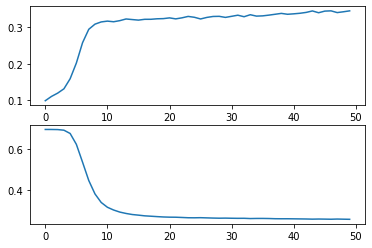

In [9]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

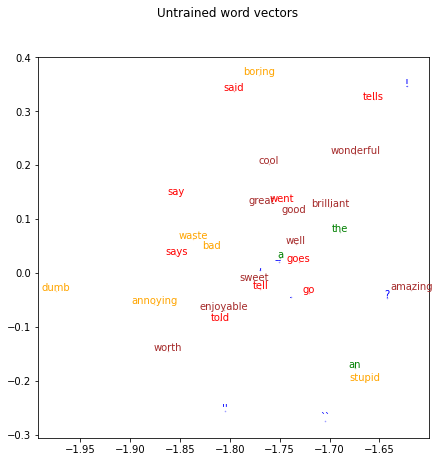

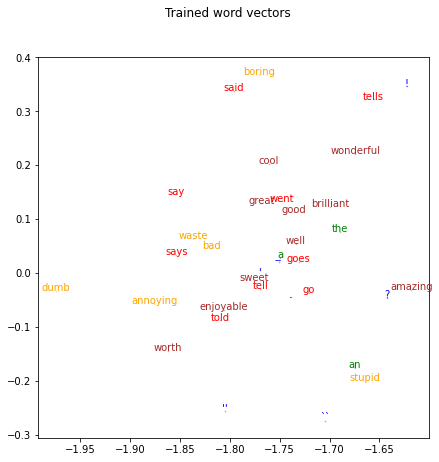

In [10]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")

In [22]:
optimizer = optim.SGD(nn_model.parameters(), lr = 7.2, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Average loss: 0.694217, Train accuracy: 0.097341
Average loss: 0.693295, Train accuracy: 0.104600
Average loss: 0.693145, Train accuracy: 0.114663
Average loss: 0.691862, Train accuracy: 0.121980
Average loss: 0.681836, Train accuracy: 0.147087
Average loss: 0.632676, Train accuracy: 0.195849
Average loss: 0.532658, Train accuracy: 0.256160
Average loss: 0.431405, Train accuracy: 0.292327
Average loss: 0.365928, Train accuracy: 0.305630
Average loss: 0.326631, Train accuracy: 0.313974
Average loss: 0.306585, Train accuracy: 0.317219
Average loss: 0.296221, Train accuracy: 0.317991
Average loss: 0.288374, Train accuracy: 0.318813
Average loss: 0.283597, Train accuracy: 0.317406
Average loss: 0.279993, Train accuracy: 0.318202
Average loss: 0.276683, Train accuracy: 0.320594
Average loss: 0.274232, Train accuracy: 0.322620
Average loss: 0.272834, Train accuracy: 0.323366
Average loss: 0.271209, Train accuracy: 0.325461
Average loss: 0.270454, Train accuracy: 0.324470


In [23]:
optimizer = optim.SGD(nn_model.parameters(), lr = 7.2, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)

loss_history_, train_history_ = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Average loss: 0.270078, Train accuracy: 0.323058
Average loss: 0.269072, Train accuracy: 0.323766
Average loss: 0.268191, Train accuracy: 0.325987
Average loss: 0.267125, Train accuracy: 0.328131
Average loss: 0.267237, Train accuracy: 0.326721
Average loss: 0.266251, Train accuracy: 0.327549
Average loss: 0.265471, Train accuracy: 0.329553
Average loss: 0.265006, Train accuracy: 0.330928
Average loss: 0.264652, Train accuracy: 0.333217
Average loss: 0.263878, Train accuracy: 0.334379
Average loss: 0.263439, Train accuracy: 0.336920
Average loss: 0.262672, Train accuracy: 0.339902
Average loss: 0.261828, Train accuracy: 0.343488
Average loss: 0.260802, Train accuracy: 0.344571
Average loss: 0.261202, Train accuracy: 0.345579
Average loss: 0.259564, Train accuracy: 0.352118
Average loss: 0.259314, Train accuracy: 0.351675
Average loss: 0.258729, Train accuracy: 0.355178
Average loss: 0.258077, Train accuracy: 0.357737
Average loss: 0.257079, Train accuracy: 0.361875


In [24]:
optimizer = optim.SGD(nn_model.parameters(), lr = 7.2, weight_decay = 0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 20)

loss_history_2, train_history_2 = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Average loss: 0.255942, Train accuracy: 0.364897
Average loss: 0.254911, Train accuracy: 0.369594
Average loss: 0.254980, Train accuracy: 0.372220
Average loss: 0.253050, Train accuracy: 0.377966
Average loss: 0.251976, Train accuracy: 0.382725
Average loss: 0.250956, Train accuracy: 0.388388
Average loss: 0.249466, Train accuracy: 0.394230
Average loss: 0.248273, Train accuracy: 0.398215
Average loss: 0.247056, Train accuracy: 0.403567
Average loss: 0.245901, Train accuracy: 0.407528


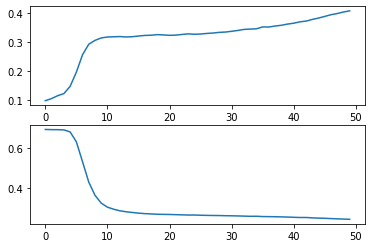

In [25]:
# Visualize training graphs
plt.subplot(211)
plt.plot([*train_history, *train_history_, *train_history_2])
plt.subplot(212)
plt.plot([*loss_history, *loss_history_, *loss_history_2])

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

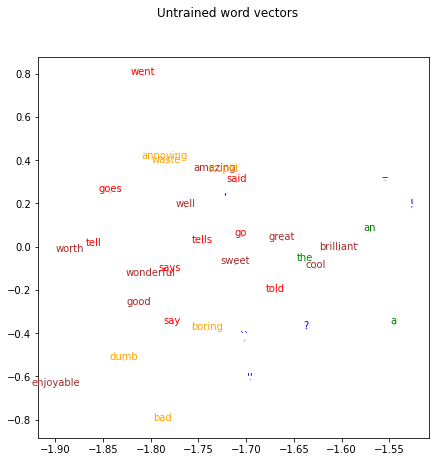

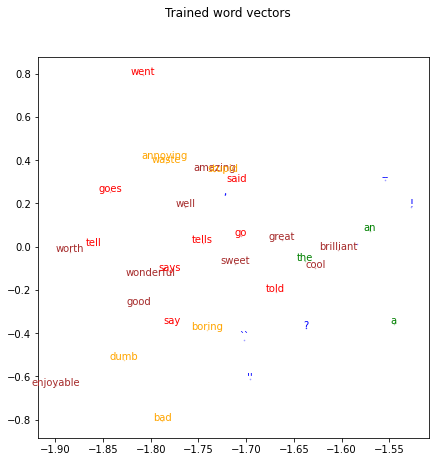

In [26]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")